In [6]:
from PIL import Image, ImageFilter
import numpy as np
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from sklearn.preprocessing import StandardScaler
from skimage import color, feature, io
from skimage import img_as_ubyte
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import cv2

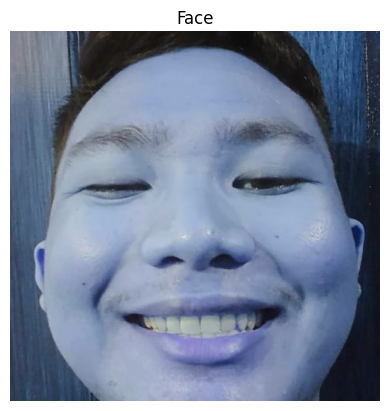

In [8]:
def extract_face(image):
    # Load the pre-trained Haar Cascade face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) > 0:
        # Assume the largest face in the image is the face of interest
        largest_face = max(faces, key=lambda rect: rect[2] * rect[3])
        x, y, w, h = largest_face
        face = image[y:y+h, x:x+w]
        return face
    else:
        return None
image = cv2.imread("../data/test_fuad.jpg")
cropped_face = extract_face(image)

if cropped_face is not None:
    plt.imshow(cropped_face)
    plt.axis('off')
    plt.title('Face')
    plt.show()
else:
    print("No face found in the image.")

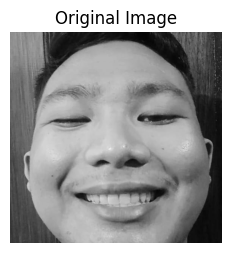

In [28]:
def convert2gray(image):
    return color.rgb2gray(image)
    
image_gray = convert2gray(cropped_face)
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image_gray, cmap='gray')
plt.axis('off')
plt.show()


C:\Users\UsEr\AppData\Local\Temp\ipykernel_12860\3720403411.py:8: RuntimeWarning: invalid value encountered in sqrt
  container[i][j] = min(255, np.sqrt(gx*2 + gy*2))


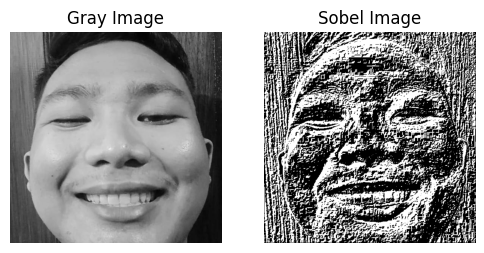

In [29]:
def sobel_operator(img):
    container = np.copy(img)
    size = container.shape
    for i in range(1, size[0] - 1):
        for j in range(1, size[1] - 1):
            gx = (img[i - 1][j - 1] + 2*img[i][j - 1] + img[i + 1][j - 1]) - (img[i - 1][j + 1] + 2*img[i][j + 1] + img[i + 1][j + 1])
            gy = (img[i - 1][j - 1] + 2*img[i - 1][j] + img[i - 1][j + 1]) - (img[i + 1][j - 1] + 2*img[i + 1][j] + img[i + 1][j + 1])
            container[i][j] = min(255, np.sqrt(gx*2 + gy*2))
    return container

image_deteksi_tepi = sobel_operator(np.array(image_gray))

plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
plt.title('Gray Image')
plt.imshow(image_gray, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Sobel Image')
plt.imshow(image_deteksi_tepi, cmap='gray')
plt.axis('off')
plt.show()

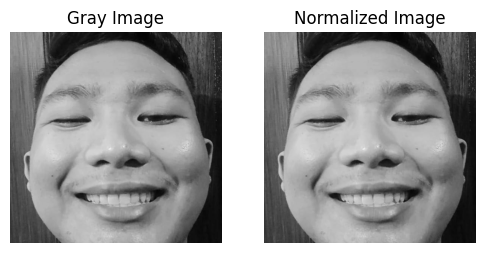

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def normalize_image(image, range_min=0, range_max=1):
    # Pastikan citra dalam format float untuk menghindari masalah pembulatan
    image = image.astype(np.float32)
    
    # Hitung nilai minimum dan maksimum dari citra
    min_val = np.min(image)
    max_val = np.max(image)
    
    # Lakukan normalisasi
    normalized_image = (image - min_val) / (max_val - min_val)
    
    # Skalakan ke rentang yang diinginkan
    normalized_image = normalized_image * (range_max - range_min) + range_min
    
    return normalized_image

image_normalized = normalize_image(image_gray)

plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
plt.title('Gray Image')
plt.imshow(image_gray, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Normalized Image')
plt.imshow(image_normalized, cmap='gray')
plt.axis('off')
plt.show()


In [31]:
def extract_lbp_features(image, radius=3, n_points=8, method='uniform'):

    # Hitung LBP
    lbp = local_binary_pattern(image, n_points, radius, method)

    # Hitung histogram LBP
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

    # Normalisasi histogram
    hist = hist.astype(float) / sum(hist)

    return hist

# Main function
if __name__ == "__main__":
    featlist = ['X1','X2','X3','X4','X5','X6','X7','X8','X9', 'X10','Y']
    final_test = []
    features = extract_lbp_features(image_normalized)
    final_test.append(features)
    df_test = pd.DataFrame(final_test)
    df_test.to_csv("Test.csv", index=False)
    print("Extracted Features:", features)
    print("Number of Features:", len(features))

Extracted Features: [0.03753364 0.06123943 0.05152554 0.1119794  0.1984295  0.15706899
 0.07458458 0.07083974 0.06797826 0.16882093]
Number of Features: 10


In [10]:
def lbph_feature_extraction(image, P=8, R=1, grid_x=8, grid_y=8):
    """
    Ekstraksi fitur menggunakan LBPH.
    image: citra grayscale input
    P: jumlah titik di sekitar lingkaran LBP (default 8)
    R: radius lingkaran LBP (default 1)
    grid_x: jumlah grid dalam sumbu x
    grid_y: jumlah grid dalam sumbu y
    """
    # Menghitung LBP dari citra
    lbp_image = local_binary_pattern(image, P, R, method="uniform")

    # Ukuran grid
    h, w = lbp_image.shape
    grid_h = h // grid_y
    grid_w = w // grid_x

    # Histogram untuk setiap grid
    histograms = []
    for i in range(grid_y):
        for j in range(grid_x):
            grid = lbp_image[i * grid_h:(i + 1) * grid_h, j * grid_w:(j + 1) * grid_w]
            hist, _ = np.histogram(grid, bins=np.arange(0, P + 3), range=(0, P + 2))
            histograms.append(hist)

    # Menggabungkan semua histogram
    histograms = np.concatenate(histograms)
    histograms = histograms / np.sum(histograms)  # Normalisasi histogram

    return histograms

# if __name__ == "__main__":
#     featlist = ['X1','X2','X3','X4','X5','X6','X7','X8','X9', 'X10','Y']
#     final_test = []
#     features = lbph_feature_extraction(image_normalized)
#     final_test.append(features)
#     df_test = pd.DataFrame(final_test)
#     df_test.to_csv("Test.csv", index=False)
#     print("Extracted Features:", features)
#     print("Number of Features:", len(features))


In [11]:
def citra_digital_proccessing(image):
    image_cropped = extract_face(image)
    image_grayscale = convert2gray(image_cropped)
    image_normalizedd = normalize_image(image_grayscale)
    image_lab = extract_lbp_features(image_normalizedd)

    return image_lab

In [14]:
def main():
    folders = ["data_1","data_2","data_3","data_4"]
    photos = ["photo_1.jpg", "photo_2.jpg", "photo_3.jpg", "photo_4.jpg", "photo_5.jpg"]
    featlist = ['X1','X2','X3','X4','X5','X6','X7','X8','X9', 'X10','Y']
    final = []

    for folder in folders:
        print(folder)
        print(folders.index(folder))
        for x in range(len(photos)):
            image = Image.open("data\\" + folder +'\\'+ photos[x])
            image_processing = citra_digital_proccessing(np.array(image))
            fitur = np.append(image_processing, folders.index(folder)+1)
            final.append(fitur)

    df = pd.DataFrame(final)
    # print(len(featlist))
    filepath = "Training.csv"
    df.to_csv(filepath, index=False)
main()

data_1
0
data_2
1
data_3
2
data_4
3


In [15]:
df = pd.read_csv("Training.csv")
print(df)

           0         1         2         3         4         5         6  \
0   0.009538  0.023328  0.029175  0.132840  0.270029  0.248280  0.076822   
1   0.010749  0.025645  0.031444  0.134987  0.279762  0.233374  0.077309   
2   0.010820  0.024973  0.031001  0.133437  0.274740  0.239624  0.075527   
3   0.012127  0.026677  0.033120  0.131460  0.267514  0.236549  0.077352   
4   0.013119  0.027067  0.034466  0.134526  0.269562  0.235547  0.076176   
5   0.069223  0.085646  0.059823  0.084027  0.128262  0.089945  0.062830   
6   0.070405  0.086325  0.060131  0.082604  0.120612  0.087023  0.059394   
7   0.068550  0.085643  0.060007  0.085042  0.130400  0.091257  0.062926   
8   0.052127  0.071155  0.059002  0.102214  0.184779  0.120169  0.064935   
9   0.073515  0.089891  0.056257  0.073558  0.109209  0.079447  0.055789   
10  0.038521  0.060782  0.040751  0.082581  0.107950  0.152310  0.087385   
11  0.027534  0.050734  0.033584  0.091476  0.118495  0.185016  0.094691   
12  0.035578